# Tech Note Demo

This notebook reproduces the figures from the [mzapy tech note](link_to_tech_note), and serves as a demonstration of the package's functionality. The data file used in this demo can be found [here](https://doi.org/10.5281/zenodo.7181929). 

_To download and run this demo notebook, first download the data file from the link above, then at the top of this page click "View page source", then right-click and save as "demo.ipynb" on your machine._

## Imports

In [1]:
from matplotlib import pyplot as plt, rcParams
import numpy as np

from mzapy import MZA
from mzapy.isotopes import MolecularFormula, monoiso_mass, predict_m_m1_m2, ms_adduct_mz
from mzapy.peaks import find_peaks_1d_gauss, find_peaks_1d_localmax
from mzapy.calibration import MassCalibration
from mzapy.view import plot_chrom, plot_spectrum, plot_atd, add_peaks_to_plot, plot_mass_calibration


## Setup

In [2]:
# increase the font size to make rendered plots more legible
rcParams['font.size'] = 10

# calculate some info for PC(18:0/18:1) [M+H]+ (C44H87NO8P)
pc_formula = MolecularFormula(C=44, H=87, N=1, O=8, P=1)
pc_mz = monoiso_mass(pc_formula)
pc_iso_masses, pc_iso_abun = predict_m_m1_m2(pc_formula)

# load the MZA file
mza = MZA('demo_data.mza', mza_version='old')


## Extract and View XIC

TIC and XIC (no fitting)


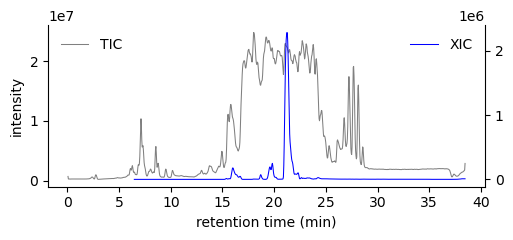

XIC with gaussian fit


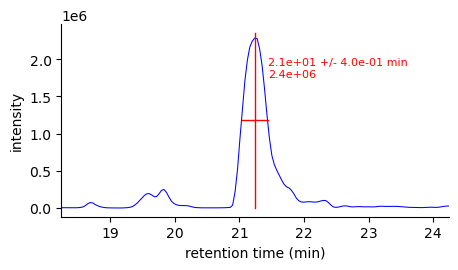

In [3]:
# extract the chromatogram for the monoiso m/z +/- 0.02
mz_min, mz_max = pc_mz - 0.02, pc_mz + 0.02
xic_rt, xic_i = mza.collect_xic_arrays_by_mz(mz_min, mz_max)

# plot TIC and XIC, without fit
print('TIC and XIC (no fitting)')
ax = plot_chrom(*mza.collect_xic_arrays_by_mz(mza.min_mz, mza.max_mz), 
                c='grey', label='TIC', figsize=(5.5, 2.5))
ax2 = ax.twinx()
for d in ['top', 'left', 'bottom']:
    ax2.spines[d].set_visible(False)
ax.legend(frameon=False, loc='upper left')
plot_chrom(xic_rt, xic_i, 
           ax=ax2, figname='show', label='XIC')

# fit XIC to get the obs. retention time, plot fitted RT for two peaks
pk_means, pk_heights, pk_widths = find_peaks_1d_gauss(xic_rt, xic_i, 
                                                      0.05, 1e3, 0.05, 
                                                      2, 1, True)
# only look for the most intense peak
pk_mean, pk_height, pk_width = pk_means[0], pk_heights[0], pk_widths[0]      

# plot the region around the fitted chromatographic peak
print('XIC with gaussian fit')
ax = plot_chrom(xic_rt, xic_i, 
                rt_range=[pk_mean - 3, pk_mean + 3], figsize=(5, 2.5))

# annotate with the fitted peak
add_peaks_to_plot(ax, pk_means, pk_heights, pk_widths, 
                  add_text_lbl=True, x_units='min', fontsize=8)

# show the plot and close
plt.show()
plt.close()


## Extract and View MS1 Spectra

MS1 spectrum (full m/z range)


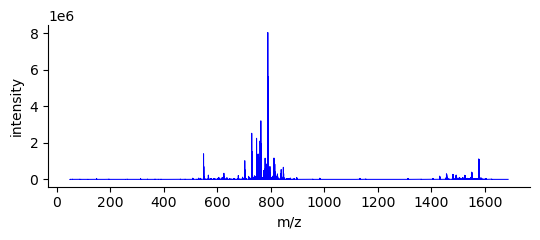

MS1 spectrum (M - 1.5 to M + 3.5)


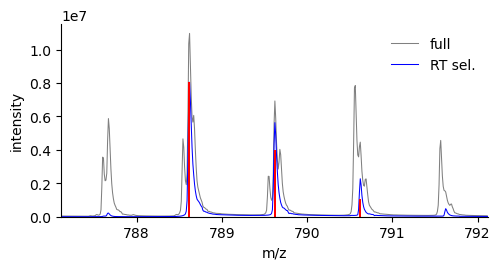

In [4]:
# extract MS1 spectrum from fitted RT +/- FWHM (full m/z range)
rt_min, rt_max = pk_mean - pk_width, pk_mean + pk_width
ms1_mz, ms1_i = mza.collect_ms1_arrays_by_rt(rt_min, rt_max)

# fit the region right around the monoisotopic mass to get the peak height of the monoisotopic peak
ms1_pk_height = find_peaks_1d_localmax(
    *mza.collect_ms1_arrays_by_rt(rt_min, rt_max, 
                                  mz_bounds=(pc_mz - 0.5, pc_mz + 0.5)), 
    0.05, 1e3, 0.01, 1, 0.2)[1][0]

# plot MS1 spectrum, full m/z range
print('MS1 spectrum (full m/z range)')
plot_spectrum(ms1_mz, ms1_i, figname='show', figsize=(5.5, 2.5))

# plot MS1 spectrum, M - 1.5 to M + 3.5
# annotate with bars corresponding to theoretical isotope distribution
print('MS1 spectrum (M - 1.5 to M + 3.5)')
ax = plot_spectrum(*mza.collect_ms1_arrays_by_rt(mza.min_rt, mza.max_rt, 
                                                 mz_bounds=(pc_mz - 1.5, pc_mz + 3.5)), 
                   mz_range=(pc_mz - 1.5, pc_mz + 3.5), c='grey', label='full', figsize=(5.5, 2.5))
plot_spectrum(ms1_mz, ms1_i, 
              mz_range=(pc_mz - 1.5, pc_mz + 3.5), ax=ax, label='RT sel.')
ax.bar(pc_iso_masses, [_ * ms1_pk_height for _ in pc_iso_abun], 
       width=0.025, color='r', zorder=2)
ax.legend(frameon=False)

# show the plot and close
plt.show()
plt.close()


## Extract and View ATD

ATD with and without RT selection


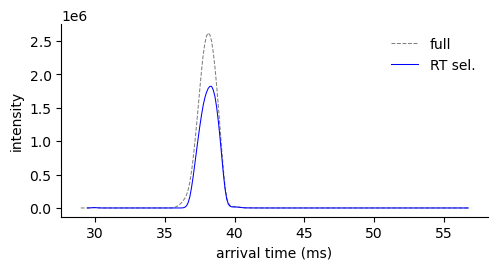

ATD with gaussian fit


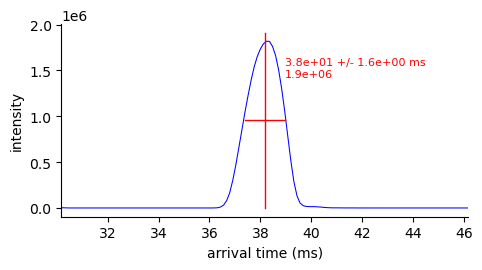

In [5]:
# extract RT and m/z selected ATD
atd_dt, atd_i = mza.collect_atd_arrays_by_rt_mz(mz_min, mz_max, rt_min, rt_max)

# It takes a very long time to get the non-RT-selected ATD, so don't run this every time
# plot ATD
ax = plot_atd(*mza.collect_atd_arrays_by_rt_mz(mz_min, mz_max, mza.min_rt, mza.max_rt),
              c='grey', ls='--', label='full', figsize=(5.5, 2.5))
plot_atd(atd_dt, atd_i, label='RT sel.', ax=ax)
ax.legend(frameon=False)

# show the plot and close
print('ATD with and without RT selection')
plt.show()
plt.close()

# fit ATD to get observed drift time
atd_means, atd_heights, atd_widths = find_peaks_1d_gauss(atd_dt, atd_i, 
                                                         0.05, 1e3, 1, 
                                                         20, 1, True)
atd_mean, atd_height, atd_width = atd_means[0], atd_heights[0], atd_widths[0]

# plot the ATD with fit
ax = plot_atd(atd_dt, atd_i, 
              dt_range=[atd_mean - 8, atd_mean + 8], figsize=(5.25, 2.5))

# annotate with the fitted peak
add_peaks_to_plot(ax, atd_means, atd_heights, atd_widths, 
                  add_text_lbl=True, x_units='ms', fontsize=8)

# show the plot and close
print('ATD with gaussian fit')
plt.show()
plt.close()


## Mass Calibration

In [6]:
# use some TGs from this sample as mass calibrants
# lipid id, molecular formula (neutral), ionization, expected retention time
mass_calibrants = [
    ['TG(50:1)', MolecularFormula(C=53, H=100, O=6), '[M+NH4]+', 27.709],
    ['TG(52:4)', MolecularFormula(C=55, H=98, O=6), '[M+NH4]+', 24.1],
    ['TG(52:3)', MolecularFormula(C=55, H=100, O=6), '[M+NH4]+', 27.253],
    ['TG(52:1)', MolecularFormula(C=55, H=104, O=6), '[M+NH4]+', 28.165],
    ['TG(54:5)', MolecularFormula(C=57, H=100, O=6), '[M+NH4]+', 26.836],
    ['TG(54:2)', MolecularFormula(C=57, H=106, O=6), '[M+NH4]+', 28.165],
    ['TG(54:1)', MolecularFormula(C=57, H=108, O=6), '[M+NH4]+', 28.563],
    ['TG(56:6)', MolecularFormula(C=59, H=102, O=6), '[M+NH4]+', 27.69],
    ['TG(56:5)', MolecularFormula(C=59, H=104, O=6), '[M+NH4]+', 27.5],
    ['TG(58:8)', MolecularFormula(C=61, H=102, O=6), '[M+NH4]+', 27.007],
]


In [7]:
# define a function for extracting the observed m/z values 
# for calibrants from the data file
def get_obs_mz(lipid, neutral_formula, adduct, exp_rt):
    """
    1. Using the lipid molecular formula and adduct, compute reference accurate m/z
    2. Extract XIC from near the expected RT, fit to obtain observed RT and peak width
    3. Extract an RT-filtered ATD, fit to obtain observed arrival time and peak width
    4. Extract an RT+DT-filtered mass spectrum and fit to determine observed m/z
    5. Return reference and observed m/z values
    """
    # 1.
    print(lipid, adduct)
    ref_mz = ms_adduct_mz(neutral_formula, adduct)
    print('reference m/z: {:.6f}'.format(ref_mz))
    # 2.
    xic_rt, xic_i = mza.collect_xic_arrays_by_mz(ref_mz - 0.01, ref_mz + 0.01, 
                                                 rt_bounds=(exp_rt - 1.5, exp_rt + 1.5))
    pk_means, pk_heights, pk_widths = find_peaks_1d_gauss(xic_rt, xic_i, 
                                                          0.05, 1e3, 0.05, 
                                                          0.5, 1, True)
    obs_rt, obs_rt_fwhm = pk_means[0], pk_widths[0]
    print('obs. RT: {:.2f} +/- {:.2f} min'.format(obs_rt, obs_rt_fwhm))
    print('XIC with fit:')
    ax = plot_chrom(xic_rt, xic_i,  figsize=(2., 2.))
    add_peaks_to_plot(ax, pk_means, pk_heights, pk_widths)
    plt.show()
    plt.close()
    # 3. 
    atd_dt, atd_i = mza.collect_atd_arrays_by_rt_mz(ref_mz - 0.01, ref_mz + 0.01, 
                                                    obs_rt - obs_rt_fwhm, obs_rt + obs_rt_fwhm)
    atd_means, atd_heights, atd_widths = find_peaks_1d_gauss(atd_dt, atd_i, 
                                                             0.05, 1e3, 1, 
                                                             20, 1, True)
    obs_dt, obs_dt_fwhm = atd_means[0], atd_widths[0]
    print('obs. DT: {:.2f} +/- {:.2f} ms'.format(obs_dt, obs_dt_fwhm))
    print('ATD with fit:')
    ax = plot_atd(atd_dt, atd_i, 
                  dt_range=[obs_dt - 5, obs_dt + 5], figsize=(2., 2.))
    add_peaks_to_plot(ax, atd_means, atd_heights, atd_widths)
    plt.show()
    plt.close()
    # 4.
    ms1_mz, ms1_i = mza.collect_ms1_arrays_by_rt_dt(obs_rt - obs_rt_fwhm, obs_rt + obs_rt_fwhm, 
                                                    obs_dt - obs_dt_fwhm, obs_dt + obs_dt_fwhm,
                                                    mz_bounds=[ref_mz - 0.25, ref_mz + 0.25])
    ms1_means, ms1_heights, ms1_widths = find_peaks_1d_gauss(ms1_mz, ms1_i, 
                                                             0.05, 1e3, 0.015, 
                                                             0.15, 1, True)
    obs_mz = ms1_means[0]
    print('obs. m/z: {:.6f}'.format(obs_mz))
    print('MS1 with fit:')
    ax = plot_spectrum(ms1_mz, ms1_i, figsize=(2., 2.))
    add_peaks_to_plot(ax, ms1_means, ms1_heights, ms1_widths)
    plt.show()
    plt.close()
    # 5. 
    return ref_mz, obs_mz
    

----------------------------------------
TG(50:1) [M+NH4]+
reference m/z: 850.786365
obs. RT: 27.69 +/- 0.17 min
XIC with fit:


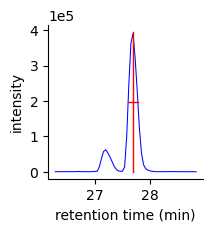

obs. DT: 41.26 +/- 1.40 ms
ATD with fit:


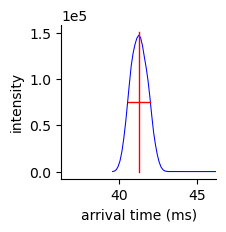

obs. m/z: 850.791254
MS1 with fit:


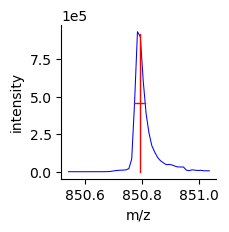

----------------------------------------
TG(52:4) [M+NH4]+
reference m/z: 872.770715
obs. RT: 24.09 +/- 0.18 min
XIC with fit:


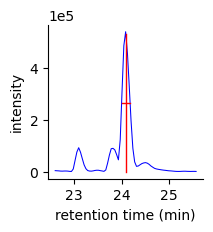

obs. DT: 41.56 +/- 1.12 ms
ATD with fit:


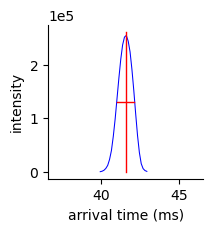

obs. m/z: 872.774762
MS1 with fit:


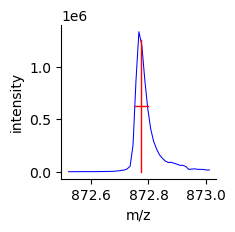

----------------------------------------
TG(52:3) [M+NH4]+
reference m/z: 874.786365
obs. RT: 27.25 +/- 0.20 min
XIC with fit:


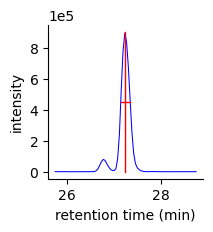

obs. DT: 41.51 +/- 1.47 ms
ATD with fit:


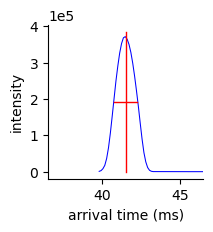

obs. m/z: 874.794993
MS1 with fit:


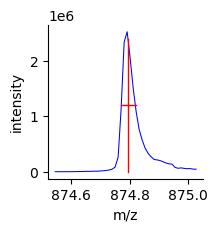

----------------------------------------
TG(52:1) [M+NH4]+
reference m/z: 878.817666
obs. RT: 28.15 +/- 0.18 min
XIC with fit:


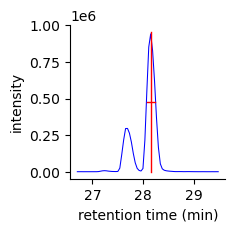

obs. DT: 42.09 +/- 1.49 ms
ATD with fit:


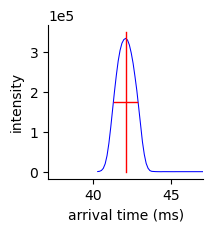

obs. m/z: 878.826442
MS1 with fit:


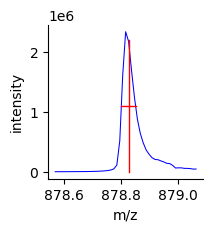

----------------------------------------
TG(54:5) [M+NH4]+
reference m/z: 898.786365
obs. RT: 26.89 +/- 0.44 min
XIC with fit:


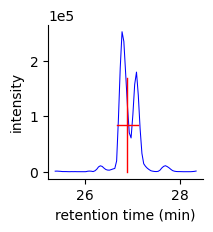

obs. DT: 41.71 +/- 1.09 ms
ATD with fit:


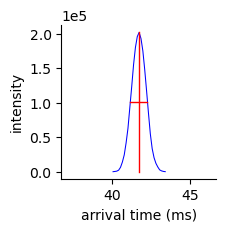

obs. m/z: 898.791653
MS1 with fit:


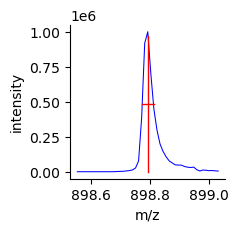

----------------------------------------
TG(54:2) [M+NH4]+
reference m/z: 904.833316
obs. RT: 28.13 +/- 0.18 min
XIC with fit:


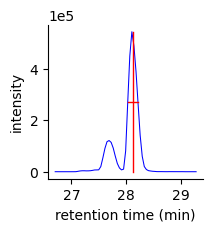

obs. DT: 42.61 +/- 1.31 ms
ATD with fit:


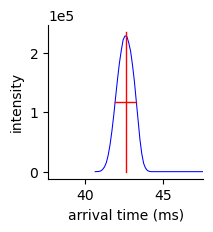

obs. m/z: 904.839460
MS1 with fit:


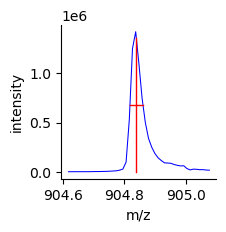

----------------------------------------
TG(54:1) [M+NH4]+
reference m/z: 906.848966
obs. RT: 28.57 +/- 0.15 min
XIC with fit:


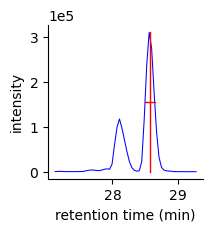

obs. DT: 42.71 +/- 1.02 ms
ATD with fit:


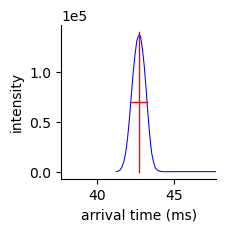

obs. m/z: 906.854695
MS1 with fit:


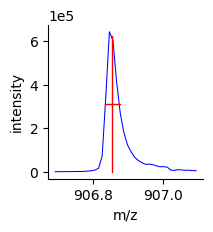

----------------------------------------
TG(56:6) [M+NH4]+
reference m/z: 924.802015
obs. RT: 27.67 +/- 0.20 min
XIC with fit:


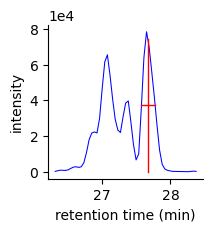

obs. DT: 42.65 +/- 1.31 ms
ATD with fit:


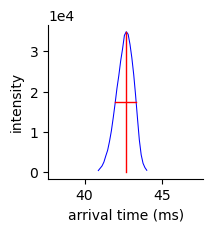

obs. m/z: 924.791458
MS1 with fit:


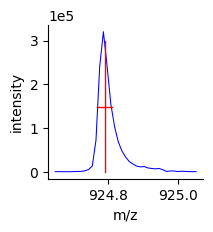

----------------------------------------
TG(56:5) [M+NH4]+
reference m/z: 926.817666
obs. RT: 27.47 +/- 0.37 min
XIC with fit:


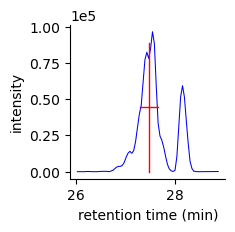

obs. DT: 42.72 +/- 1.05 ms
ATD with fit:


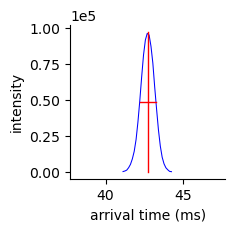

obs. m/z: 926.820352
MS1 with fit:


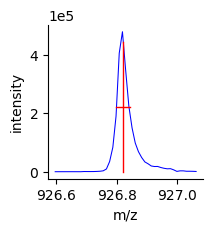

----------------------------------------
TG(58:8) [M+NH4]+
reference m/z: 948.802015
obs. RT: 27.00 +/- 0.16 min
XIC with fit:


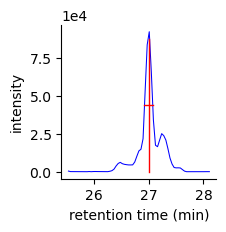

obs. DT: 42.80 +/- 1.00 ms
ATD with fit:


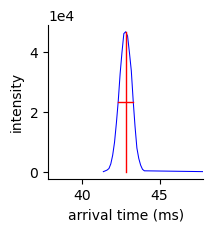

obs. m/z: 948.806533
MS1 with fit:


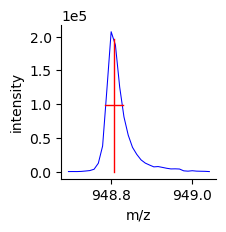

----------------------------------------


In [8]:
ref_mzs, obs_mzs = [], []
for calibrant in mass_calibrants:
    print('-' * 40)
    ref_mz, obs_mz = get_obs_mz(*calibrant)
    ref_mzs.append(ref_mz)
    obs_mzs.append(obs_mz)
print('-' * 40)

# convert to numpy ndarrays
ref_mzs, obs_mzs = np.array([ref_mzs, obs_mzs])


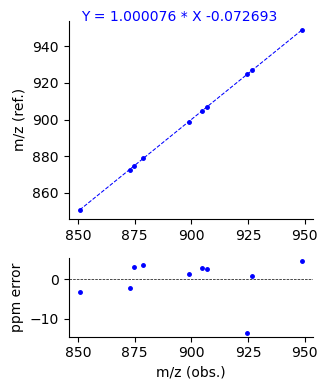

In [9]:
# construct the calibration
mz_cal = MassCalibration(ref_mzs, obs_mzs, 'linear')

# plot calibration results
plot_mass_calibration(mz_cal, figname='show')


## Cleanup

In [10]:
# close the MZA interface
mza.close()
